In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

import os
import shutil
import time
import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
import torchvision
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR, StepLR
import torchvision.transforms as T
from torch.autograd import Variable
from facenet_pytorch import InceptionResnetV1
from torchvision import models
from torch.utils.tensorboard import SummaryWriter

import sklearn.metrics as metrics

In [1]:
import os
len(os.listdir(r"..\CASIA-WebFace\train"))

8460

In [2]:
path_train = r"../data/data_resnet\train"
path_test = r"../data/data_resnet\test"
path_validation = r"../data/data_resnet\val"

In [3]:
BATCH_SIZE = 64
N_EPOCHS =100
FEATURE_EXTRACT = True
PATH = r'..\results\vgg_pretraining'

In [4]:
# def triplet_loss(x_p, x_n, x_a, margin):

#     dist_pa = torch.pow(torch.nn.functional.pairwise_distance(x_p, x_a), 2)
#     dist_na = torch.pow(torch.nn.functional.pairwise_distance(x_n, x_a), 2)
    
#     return torch.mean(torch.clamp(dist_pa - dist_na + margin, min=0.0)) 

In [5]:
#here we apply data aougmantation and scaling for images only for train
transform = T.Compose([
      T.Resize((160, 160)),
#                                   transforms.RandomHorizontalFlip(),
#                                   transforms.RandomVerticalFlip(),
#                                   transforms.RandomRotation(center=(100,100),degrees=(0,90)),
#     T.RandomBrightness(0.5),
    T.ColorJitter(brightness=[1,1.7], contrast=[1,1.7], saturation=0, hue=0),
    T.ToTensor(),  
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    T.RandomErasing(p=0.2),

])

In [6]:
class DatasetSiamese(Dataset):
    def __init__(self, img_dir, transform=None, train = True):
        self.img_dir = img_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return BATCH_SIZE*100

    def __getitem__(self, idx ):
        var = True
        while var:
            l = random.sample(os.listdir(self.img_dir), 2)
            folder1=os.path.join(self.img_dir, l[0])
            folder2=os.path.join(self.img_dir, l[1])

            f1=os.listdir(folder1)
            anchor = random.choice(f1)
            f1.remove(anchor)
            positive = random.choice(f1)
            negative = random.choice(os.listdir(folder2))

            path_a = os.path.join(folder1, anchor)
            path_p = os.path.join(folder1, positive)
            path_n = os.path.join(folder2, negative)

            label_p = os.path.basename(folder1)
            label_n = os.path.basename(folder2)
            try:
                image_a = Image.open(os.path.join(folder1, anchor)).convert('RGB')
                image_p = Image.open(os.path.join(folder1, positive)).convert('RGB')
                image_n = Image.open(os.path.join(folder2, negative)).convert('RGB')
                var = False

            except:
                var = True
                
        if self.transform is not None:
            image_a = self.transform(image_a)
            image_p = self.transform(image_p)
            image_n = self.transform(image_n)
        
        if self.train:
            return image_a, image_p, image_n 
        else:
            return image_a, image_p, image_n, path_a, path_p, path_n, label_p, label_n 

In [7]:
dataset_train = DatasetSiamese(path_train, transform = transform)
train_loader = DataLoader(dataset_train,shuffle=False,batch_size=BATCH_SIZE)

dataset_test = DatasetSiamese(path_test,transform=transform, train=False)
test_loader = DataLoader(dataset_test,shuffle=False,batch_size=1)

dataset_valid = DatasetSiamese(path_validation,transform=transform, train=False)
valid_loader = DataLoader(dataset_valid,shuffle=False,batch_size=BATCH_SIZE)

In [8]:
dataset_valid_logistic = DatasetSiamese(path_validation,transform=transform, train=False)
valid_loader_logistic = DataLoader(dataset_valid_logistic,shuffle=False,batch_size=1)

dataset_train_logistic = DatasetSiamese(path_train,transform=transform, train=True)
train_loader_logistic = DataLoader(dataset_train_logistic,shuffle=False,batch_size=1)

In [9]:
def show_image(img, figsize=(20, 20)):
    img = np.array(img)
    d = img.transpose(1, 2, 0)
    plt.figure(figsize=figsize)
    plt.imshow(d)
    plt.show()

In [10]:
def plot_loss(train_list, validation_list, figsize):
    """Plot losses during train and validation

    Args:
      train_list: array of train losses based on epoch
      validation_list: array of validation losses based on epoch
      figsize: size of the plot
    """
    plt.figure(figsize = figsize)

    plt.title("Loss of CRNN")
    plt.plot(train_list, label="Train Loss")
    plt.plot(validation_list, label = "Validation Los")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

In [11]:
def plot_distances(dataiter):
    for idx in range(BATCH_SIZE):
        image_a = Image.open(dataiter[3][idx])
        image_p = Image.open(dataiter[4][idx])
        image_n = Image.open(dataiter[5][idx])

        vec_a, vec_p, vec_n = model(dataiter[0], dataiter[1], dataiter[2])

        dist_ap = torch.nn.functional.pairwise_distance(vec_a[idx], vec_p[idx])
        dist_an = torch.nn.functional.pairwise_distance(vec_a[idx], vec_n[idx])

        f, axarr = plt.subplots(1, 3)
        axarr[0].imshow(image_a)
        axarr[1].imshow(image_p)
        axarr[2].imshow(image_n)

        plt.text(600, 100, f'{dataiter[6][idx]}, {dataiter[6][idx]}, {dataiter[7][idx]}\n similarity score : {dist_ap}\n dissimilarity score {dist_an}\n ', horizontalalignment='center',
     verticalalignment='center', fontsize = 12,  bbox = dict(facecolor = 'white', alpha = 1))
        plt.show()

In [12]:
dataiter = next(iter(train_loader))
print('length:', len(dataset_train))
print('items in batch:', len(dataiter))

length: 6400
items in batch: 3


In [13]:

dataiter = next(iter(valid_loader))
print('length:', len(dataset_valid))
print('items in batch:', len(dataiter))

length: 6400
items in batch: 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


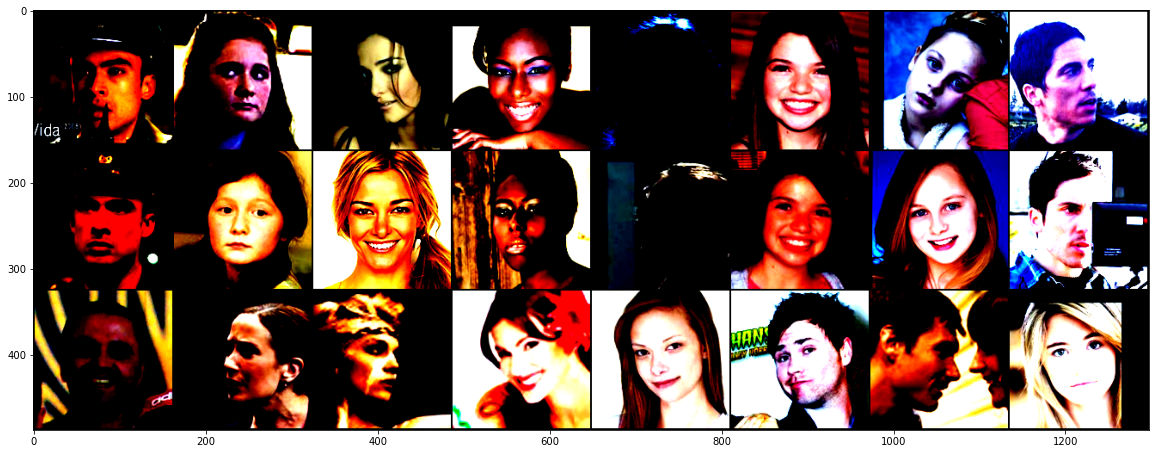

In [15]:
concatenated = torch.cat((dataiter[0][:8], dataiter[1][:8],dataiter[2][:8]),0)
show_image(torchvision.utils.make_grid(concatenated))

In [16]:
def calculate_metric(x_a, x_p, x_n):
    dist_p = torch.pow(torch.nn.functional.pairwise_distance(x_p, x_a), 2)
    dist_n = torch.pow(torch.nn.functional.pairwise_distance(x_n, x_a), 2)
    
    a =  dist_p < dist_n
    z = a.unique(return_counts=True)
    if True in z[0]:
        index = (z[0] == True).nonzero(as_tuple=True)[0].item()
        acc = z[1][index]/len(a)
    else:
        acc = 0
    return acc
# T / T + F

In [17]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [18]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cpu")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [19]:
N_BATCHES = len(dataset_train)/BATCH_SIZE

In [20]:
# model inception v1
class SiameseFaceRecognition(nn.Module):
    
    def __init__(self):
        super(SiameseFaceRecognition, self).__init__()
        resnet_custom = InceptionResnetV1().eval()
        
        self.model_custom = resnet_custom
        
         
    def forward_once(self, x):
            
        return self.model_custom(x)
    
    def forward(self, imageA, imageP,imageN = None):
        if imageN is not None:
            resultA = self.forward_once(imageA)
            resultP = self.forward_once(imageP)
            resultN = self.forward_once(imageN)
            return resultA, resultP,resultN
        
        resultA = self.forward_once(imageA)
        resultP = self.forward_once(imageP)             
        return resultA, resultP

In [21]:
model = SiameseFaceRecognition()

#moving to gpu
model.to(device)

print(model)

SiameseFaceRecognition(
  (model_custom): InceptionResnetV1(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.

In [23]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size = 10)

In [24]:
# random model loss and score

In [25]:
running_train_loss=0
running_valid_loss=0
running_train_acc=0
running_valid_acc=0
best_loss = float("inf")

    
with torch.no_grad():
    for j,data in enumerate(train_loader):
        optimizer.zero_grad()
        result_a, result_p, result_n = model(data[0].to(device), data[1].to(device), data[2].to(device))

        loss_net = triplet_loss(result_p, result_n, result_a, 1)
        acc_train = calculate_metric(result_a, result_p, result_n)
        
        running_train_loss += loss_net.item()
        running_train_acc += acc_train.item()
        
        torch.cuda.empty_cache()    


    for j,data in enumerate(valid_loader):

        optimizer.zero_grad()
        result_a, result_p, result_n = model(data[0].to(device), data[1].to(device), data[2].to(device))


        loss_net = triplet_loss(result_p, result_n, result_a, 1)
        acc_valid = calculate_metric(result_a, result_p, result_n)
        
        running_valid_loss += loss_net.item()
        running_valid_acc += acc_valid.item()

   
    print("="*50)
    print("train loss= "+str(running_train_loss/N_BATCHES))
    print("train acc= "+str(running_train_acc/N_BATCHES))
    
    print("validation loss= "+str(running_valid_loss/N_BATCHES))
    print("validation acc= "+str(running_valid_acc/N_BATCHES))

train loss= 0.9999559509754181
train acc= 0.54109375
validation loss= 0.9999497580528259
validation acc= 0.553125


In [26]:
running_train_loss=[]
loss_train=[]
running_valid_loss=[]
loss_valid=[]
running_train_acc=[]
running_valid_acc=[]

In [27]:
# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch_ = checkpoint['epoch']
# loss = checkpoint['loss']

In [28]:
best_loss = float("inf")
model.train()
for i in tqdm(range(N_EPOCHS)):
    print('epoch ' + str(i))
    for j,data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        result_a, result_p, result_n = model(data[0].to(device), data[1].to(device), data[2].to(device))
        
        acc_train = calculate_metric(result_a, result_p, result_n)
        loss_net = triplet_loss(result_p, result_n, result_a, 1)
        
        
        loss_net.backward()
        optimizer.step()
        scheduler.step()
        
        running_train_acc.append(acc_train.item())
        running_train_loss.append(loss_net.item())
        torch.cuda.empty_cache()
        

    loss_train.append(sum(running_train_loss)/len(running_train_loss))  
    
    with torch.no_grad():
        model.eval()
        for j,data in tqdm(enumerate(valid_loader)):
            
            optimizer.zero_grad()
            result_a, result_p, result_n = model(data[0].to(device), data[1].to(device), data[2].to(device))
            
            acc_valid = calculate_metric(result_a, result_p, result_n)
            loss_net = triplet_loss(result_p, result_n, result_a, 1)
            
            running_valid_loss.append(loss_net.item())
            running_valid_acc.append(acc_valid.item())
            
        loss_train_temp = sum(running_train_loss)/len(running_train_loss) 
        loss_valid_temp = sum(running_valid_loss)/len(running_valid_loss) 
        
        acc_train_temp = sum(running_train_acc)/len(running_train_acc) 
        acc_valid_temp = sum(running_valid_acc)/len(running_valid_acc) 
        
        loss_valid.append(loss_valid_temp)
        
        if (loss_valid_temp < best_loss):
            print(f"Loss decresed to {loss_valid_temp} from {best_loss}")
            best_loss = loss_valid_temp
            
            torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
                'acc': acc_valid_temp
            }, PATH)
            
        print("="*50)
        print("train loss= "+str(loss_train_temp))
        print("train acc= "+str(acc_train_temp))
        print("validation loss= "+str(loss_valid_temp))
        print("validation acc= "+str(acc_valid_temp))
            
        running_valid_loss=[]
        running_train_loss=[]
        running_train_acc=[]
        running_valid_acc=[]  
              

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch 0


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Loss decresed to 1.02760639667511 from inf
train loss= 0.9090156495571137
train acc= 0.57640625
validation loss= 1.02760639667511
validation acc= 0.588125
epoch 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss= 0.9925918060541153
train acc= 0.59328125
validation loss= 1.044157599210739
validation acc= 0.57875
epoch 2


0it [00:00, ?it/s]

KeyboardInterrupt: 

In [32]:
dataiter = next(iter(valid_loader))

plot_distances(dataiter)